<font size="+3"><strong>3 Air Quality in Nairobi 🇰🇪</strong></font>

<font size="+2"><strong>3.5 Air Quality in Dar es Salaam 🇹🇿</strong></font>

This notebook resumes the most important things learned in the WorldQuant course 3 Applied Data Science Lab - Air Quality in Nairobi". It uses the courses' project "Air Quality in Dar es Salaam" since it implements the main ideas learned.

In this project, we''ll work with data from one of Africa's largest open data platforms openAfrica. We'll also look at air quality data from Nairobi, Lagos, and Dar es Salaam; and build a time series model to predict PM 2.5 readings throughout the day.

Topics learned in this project:

- How to get data by querying a MongoDB database.
- How to prepare time series data for analysis.
- How to build an autoregression model.
- How to improve a model by tuning its hyperparameters.

Imports necessary libraries:

In [1]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

# Prepare Data

## Connect

Establishes the IP address on the MongoDB server:

In [2]:
host = "localhost"

MongoDB data is organized in the following hierarchical order: 
1. database:
    - a MongDB server can host multiple databases
    - they have to be accessed through a Client
    
2. collection:
    - a collection stores a group of documents
    - contains semi-structured data, this means different documents can have different features
    
3. document:
    - basic unit of data in MongoDB
    - stored in BSON (Binary JSON), which supports more types than JSON (e.g., dates, binary data)

`PrettyPrinter` makes the information MongoDB generates easier to understand:

In [3]:
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=2)

In [4]:
# connects with DataBase
client = MongoClient(host=host, port=27017)

# lists databases available ion the server
pp.pprint(list(client.list_databases()))

# gets database
db = client["air-quality"]

# lists collections available in 'db'
db.list_collections()

# assigns the 'dar-es-salaam' collection to a variable
dar = db["dar-es-salaam"]

[ {'empty': False, 'name': 'admin', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'air-quality', 'sizeOnDisk': 5918720},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 110592},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'wqu-abtest', 'sizeOnDisk': 1069056}]


## Explore

In [5]:
# checks how many documents are in the 'dar' collection
dar.count_documents({})

233262

In [6]:
# determines how many sensor sites are included in the 'dar' collection
sites = dar.distinct("metadata.site")
sites

[11, 23]

In [7]:
# determines how many readings there are for each site in the 'dar' collection
dar.count_documents({"metadata.site": 11}) 

173242

In [8]:
# determines how many readings there are for each site in the nairobi collection
result = dar.aggregate(
    [
        {"$group": {"_id": "$metadata.site", "count": {"$count": {}}}}
    ]
)

readings_per_site = list(result)
readings_per_site

[{'_id': 11, 'count': 173242}, {'_id': 23, 'count': 60020}]

## Import

In [9]:
# retrives one random document from the 'dar' collection
# a document is stored as a dictionary
dar.find_one({})

{'timestamp': datetime.datetime(2018, 1, 1, 0, 0, 48, 41000),
 'metadata': {'lat': -6.818,
  'lon': 39.285,
  'measurement': 'temperature',
  'sensor_id': 34,
  'sensor_type': 'DHT22',
  'site': 11},
 'temperature': 30.1,
 '_id': ObjectId('6525d778f44bfedd842c72d8')}

### TimeSeries

- MongoDB stores all timestamps in UTC
- in this <code>wrangle</code> function the time data is converted to Africa/Dar_es_Salaam timezone

In [10]:
def wrangle(collection):
    
    # Retrives the PM2.5 readings from site 11
    # Uses the projection argument to limit the results to the "P2" and "timestamp" keys only
    result = collection.find(
        {"metadata.site": 11, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )
    
    # Read results into DataFrame
    df = pd.DataFrame(list(result)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

    # Remove outliers w/ readings above 100
    df = df[df["P2"] < 101]

    # Resamples to 1-hour window mean values
    # Imputes missing values using the forward-fill method
    df = df["P2"].resample("1h").mean().ffill().to_frame()

    # squeeze() method converts 1-column DataFrame into a Series
    return df.squeeze()

In [11]:
y = wrangle(dar)
print(type(y))

<class 'pandas.core.series.Series'>


## Explore Some More

Creates a time series plot of the readings in <code>y</code>:

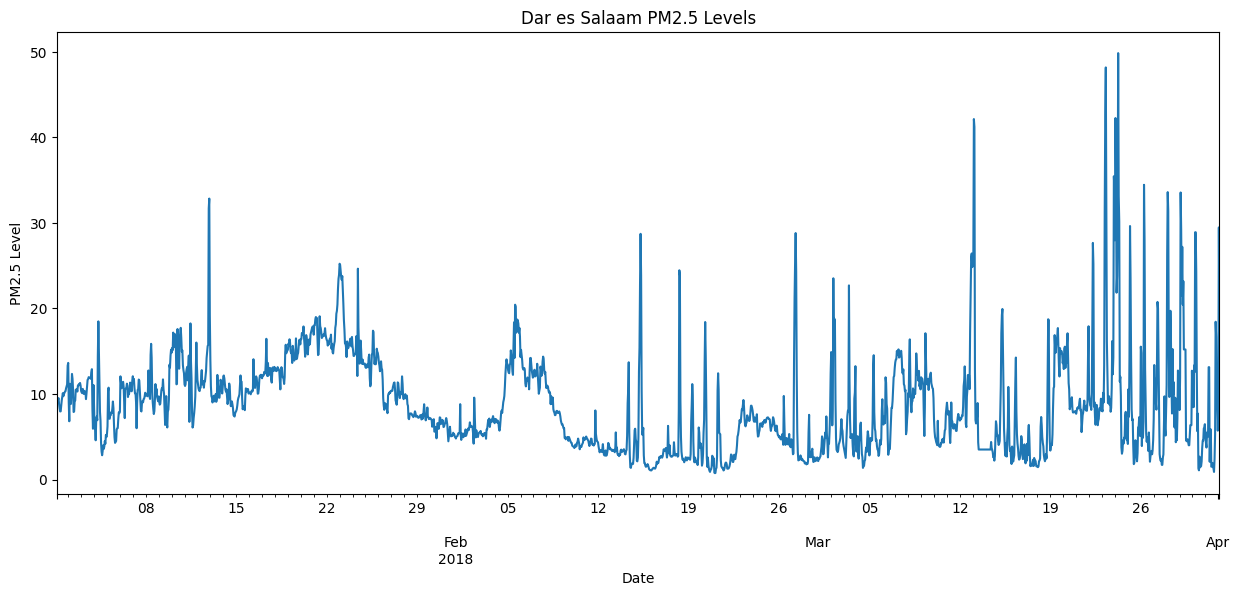

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))

# use ax=ax in your plot
y.plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level", title="Dar es Salaam PM2.5 Levels");

### Rolling Windows

Rolling window is an important concept for time series analysis. We first define a window size, like 7 days, three months, etc. 

Then we calculate some statistics taking data from each window sequentially throughout the time series.

Rolling window statistics are very helpful in smoothing noisy data when making time series predictions.

Plots the rolling average of the readings in <code>y</code>. 

Uses a window size of 168 (the number of hours in a week):

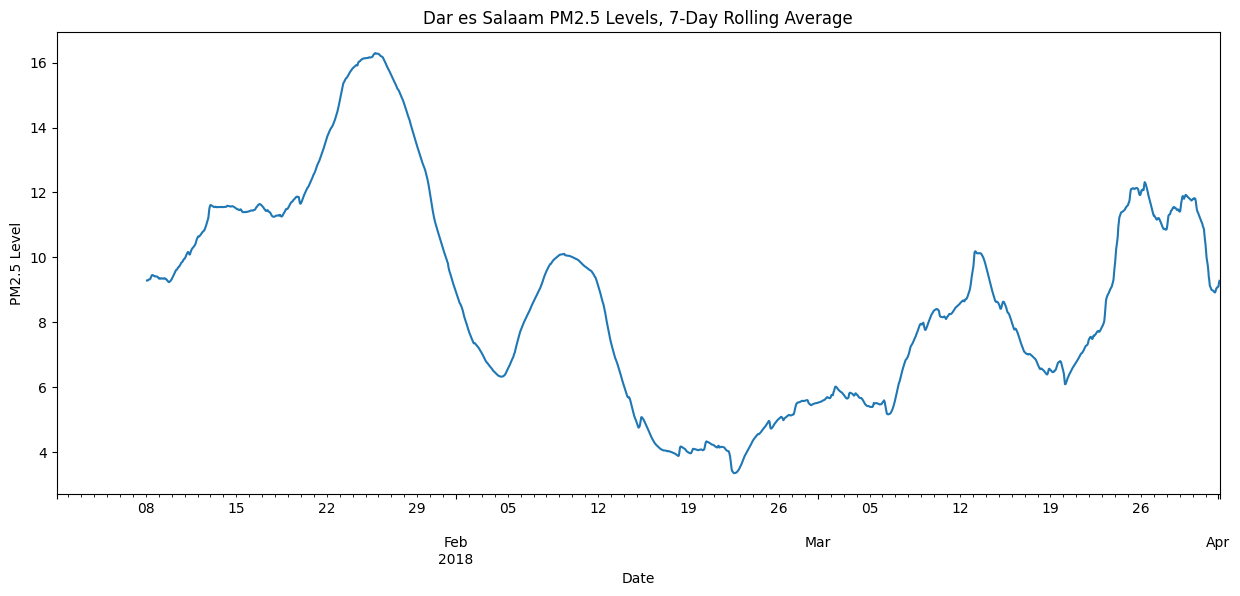

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))

# use ax=ax in your plot
y.rolling(168).mean().plot(
    ax=ax, 
    xlabel="Date", 
    ylabel="PM2.5 Level", 
    title="Dar es Salaam PM2.5 Levels, 7-Day Rolling Average"
);

ACT and PACT plots help understand the correlation between y and previous values of y. 

We want to compare our ACF and PACF plots to see which model best describes our time series. 

If the ACF data drops off slowly, then that's going to be a better description; if the PACF falls off slowly, then that's going to be a better description.


### ACF Plot

An Autocorrelation Function (ACF) plot is created so we can see how autocorrelations change over time.

Creates an ACF plot for the data in <code>y</code>:

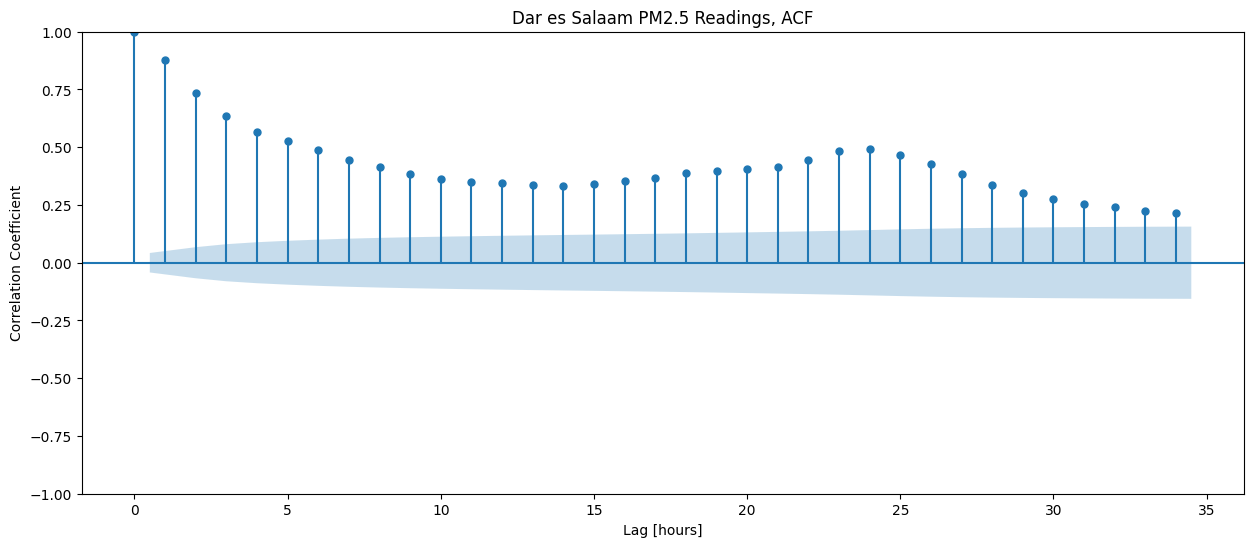

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

# use ax=ax in your plot
plot_acf(y, ax=ax)

ax.set_xlabel("Lag [hours]")
ax.set_ylabel("Correlation Coefficient")

ax.set_title("Dar es Salaam PM2.5 Readings, ACF");

### PACF

The Partial ACF (PACF) takes into account the echo between values.

It should be used to determine which previous values of y should be used in the predictive model

Creates an PACF plot for the data in <code>y</code>:

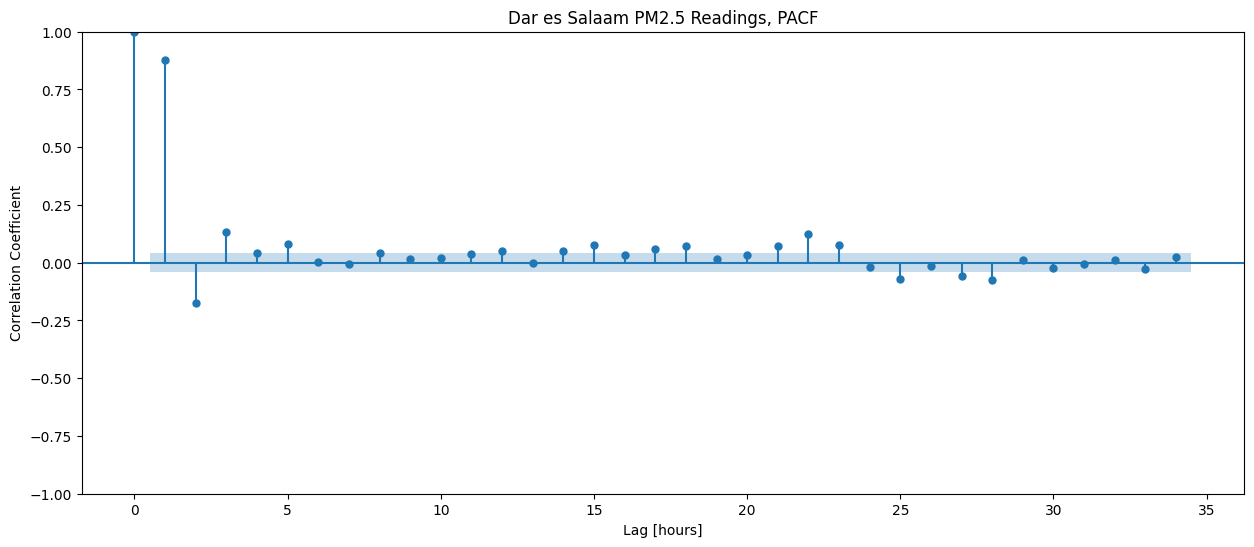

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))

# Use ax=ax in your plot

plot_pacf(y, ax=ax)

ax.set_xlabel("Lag [hours]")
ax.set_ylabel("Correlation Coefficient")

ax.set_title("Dar es Salaam PM2.5 Readings, PACF");

## Split

Splits <code>y</code> into training and test sets:

In [16]:
cutoff_test = int(0.9 * len(y))
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1944,)
y_test shape: (216,)


# Build Model

## Baseline

Establishes the baseline mean absolute error for the model.

The baseline MEA is considers a model where the prediction is always the mean value of the training predictions. 

In [17]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.57142319061077
Baseline MAE: 4.053101181299159


## Model Types

### Autoregression Models

Autoregression (AR) is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. 

AR works in a similar way to autocorrelation: in both cases, we're taking data from one part of a set and comparing it to another part. An AR model regresses itself.

### ARMA Models

ARMA stands for Auto Regressive Moving Average, and it's a special kind of time-series analysis. 

AR models rely on values that remain relatively stable over time. That is, they can predict the future very well, as long as the future looks roughly the same as the past. 

The trouble with predicting the future is that things can suddenly change, and as a result, the future doesn't look much like the past anymore. 

These sudden changes can be as big as a hurricane destroying a city or an unexpected increase in the minimum wage, and they can be as small as a new restaurant opening in a neighborhood or a single person losing their job. 

In our data, the air quality might be changed if there was a nearby forest fire, or if a building collapsed near one of the sensors and raised a giant cloud of dust.

## Iterate

### Lags

Lagging data means that we're adding a delay. In this case, we're going to allow the model to test itself out by comparing its predictions for different hour lags. 

If the prediction and the reality are close, then it's a good model; if they aren't, then the model isn't a very good one.

The following code aims to determine which hyperparameter setting will give me the best performance.

To predict PM2.5 readings, it uses an AutoReg model.

The <code>for</code> loop is used to train the AR model on using settings for lags from 1 to 30. 

Each time a new model is trained, it calculates its MEA and appends the result to a list.

The results are stored in a list.

In [18]:
# Create range to test different lags
p_params = range(1, 31)

# Create empty list to hold mean absolute error scores
maes = []

# Iterate through all values of p in `p_params`
for p in p_params:
    # Build model
    model = AutoReg(y_train.copy(), lags=p).fit()

    # Make predictions on training data, dropping null values caused by lag
    y_pred = model.predict().dropna()

    # Calculate mean absolute error for training data vs predictions
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)

    # Append `mae` to list `maes`
    maes.append(mae)

# Put list `maes` into Series with index `p_params`
mae_series = pd.Series(maes, name="mae", index=p_params)

# Inspect head of Series
mae_series.head()

1    1.059376
2    1.045182
3    1.032489
4    1.032147
5    1.031022
Name: mae, dtype: float64

Determines which value for <code>p</code> provides the best performance.

Build a model for that value:

In [19]:
best_p = min(mae_series.index, key=mae_series.get)
best_model = AutoReg(y_train, lags=best_p).fit()

### Residuals

<code>y_train_resid = y_train - y_pred</code>

Calculates the training residuals for <code>best_model</code>:

In [20]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid

timestamp
2018-01-02 05:00:00+03:00   -0.412913
2018-01-02 06:00:00+03:00    1.484934
2018-01-02 07:00:00+03:00    1.672359
2018-01-02 08:00:00+03:00   -0.368030
2018-01-02 09:00:00+03:00   -0.536868
                               ...   
2018-03-22 22:00:00+03:00   -0.157974
2018-03-22 23:00:00+03:00   -1.114870
2018-03-23 00:00:00+03:00    0.495103
2018-03-23 01:00:00+03:00    0.030638
2018-03-23 02:00:00+03:00    2.401650
Freq: h, Name: residuals, Length: 1918, dtype: float64

Creates a histogram of <code>y_train_resid</code>:

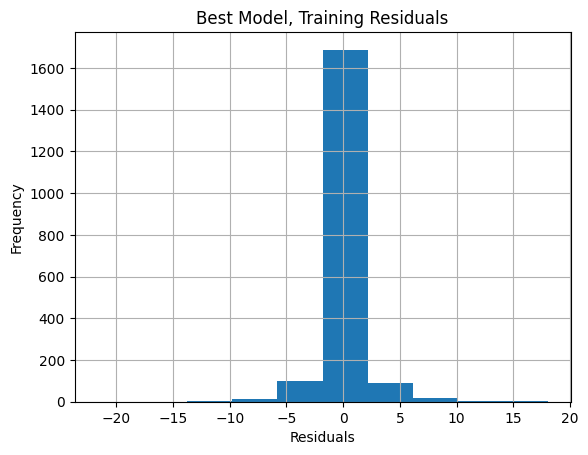

In [21]:
# Plot histogram of residuals
fig, ax = plt.subplots()

# Use ax=ax in your plot
y_train_resid.hist(ax=ax)

ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
ax.set_title("Best Model, Training Residuals");

Creates an ACF plot for <code>y_train_resid</code>:

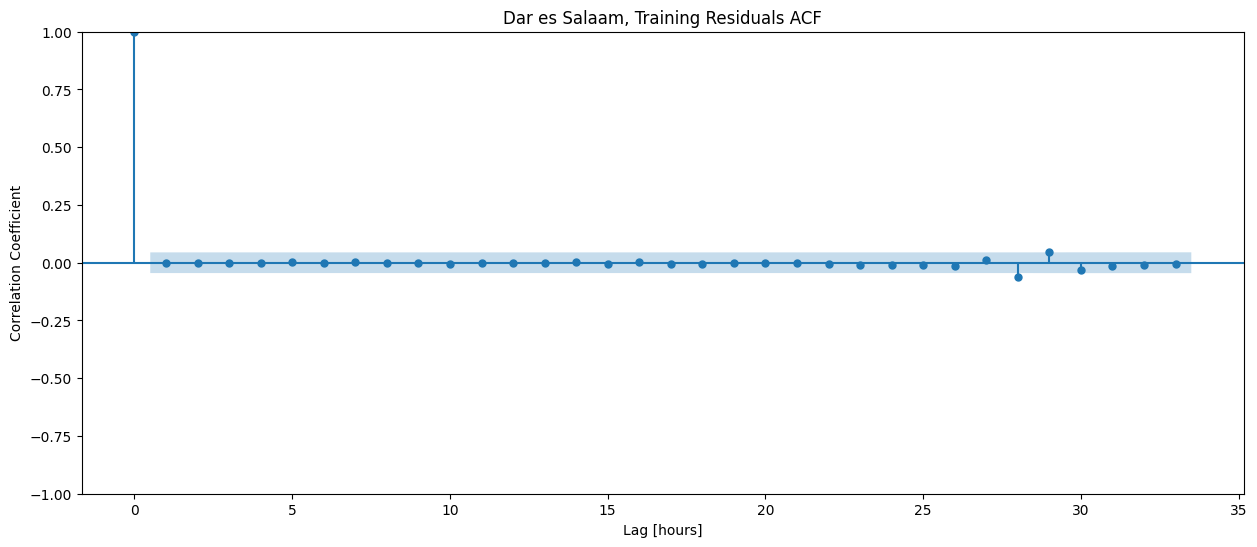

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

# Use ax=ax in your plot
plot_acf(y_train_resid, ax=ax)
ax.set_xlabel("Lag [hours]")
ax.set_ylabel("Correlation Coefficient")
ax.set_title("Dar es Salaam, Training Residuals ACF");

## Evaluate

### Walk-forward Validation

Our predictions lose power over time because the model gets farther and farther away from its beginning. 

But what if we could move that beginning forward with the model? That's what **walk-forward validation** is. 

In a walk-forward validation, we re-train the model at for each new observation in the dataset, dropping the data that's the farthest in the past. 

Let's say that our prediction for what's going to happen at 12:00 is based on what happened at 11:00, 10:00, and 9:00. 

When we move forward an hour to predict what's going to happen at 1:00, we only use data from 10:00, 11:00, and 12:00, dropping the data from 9:00 because it's now too far in the past.

Performs walk-forward validation for the model for the entire test set <code>y_test</code>:

In [23]:
y_pred_list = []
history = y_train.copy()

for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred=model.forecast()
    y_pred_list.append(next_pred.iloc[0])

    # Add current y_test value to history
    history = pd.concat([history, y_test.iloc[[i]]])

y_pred_wfv = pd.Series(y_pred_list, index=y_test.index, name="prediction")
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2018-03-23 03:00:00+03:00    10.414744
2018-03-23 04:00:00+03:00     8.269589
2018-03-23 05:00:00+03:00    15.178677
2018-03-23 06:00:00+03:00    33.475398
2018-03-23 07:00:00+03:00    39.571363
Freq: h, Name: prediction, dtype: float64

Calculates MAE:

In [24]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 3.97


# Commmunicate Results

Plots <code>df_pred_test</code> using plotly express:

In [25]:
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred_wfv": y_pred_wfv}, index=y_test.index)
fig = px.line(df_pred_test)
fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
);

fig.update_layout()
fig.show()